In [1]:
%load_ext autoreload
%autoreload 2

# Setup Paths

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "text_classification_problems" / "configs"
os.chdir(root / "text_classification_problems")

In [3]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from text_classification_problems.datamodule import TextClassifierDataModule
from text_classification_problems.modelmodule import TextClassifierModel
from transformers import AutoTokenizer
from tqdm import tqdm

import matplotlib.pyplot as plt

/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config  

In [4]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=imdb", "tracer=gd"])

In [5]:
device = 'cuda:0'

# Load Data and Model

In [6]:
from datamodule import TextClassifierDataModule

In [9]:
checkpoint = torch.load("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt", map_location=device)
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=True
)
dm.prepare_data()
dm.setup("tracing")

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 28.8kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 570kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 262kB/s]  
Downloading: 100%|██████████| 466k/466k [00:01<00:00, 406kB/s]  


In [11]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=1e-3,
)
lit_model.load_state_dict(checkpoint["state_dict"])
net = lit_model.net
lit_model.eval()
lit_model.to(device);

Downloading: 100%|██████████| 440M/440M [00:25<00:00, 17.1MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
train_loader = dm.train_dataloader(shuffle=False)

## KNN Indexs

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
def cal_neibor_matrices(lit_model, ref_loader, trace_loader, k=100):
    k = k + 1
    features = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(ref_loader):
            batch = tree_to_device(batch, device)
            features.append(lit_model.feature(batch).cpu())
            labels.append(batch['label'].cpu())
        features = torch.concat(features).numpy()
        labels = torch.concat(labels).numpy()
        neigh = KNeighborsClassifier(n_neighbors=k, metric='minkowski', algorithm='kd_tree', n_jobs=-1)
        neigh.fit(features, labels)

        neibor_inds = []
        for batch in tqdm(trace_loader):
            batch = tree_to_device(batch, device)
            trace_feature = lit_model.feature(batch).cpu()
            neibor_inds.append(neigh.kneighbors(trace_feature, n_neighbors=k, return_distance=False))
        neibor_inds = np.concatenate(neibor_inds, axis=0)
        neibor_inds = torch.tensor(neibor_inds)
    return neibor_inds

In [69]:
neibor_inds = cal_neibor_matrices(lit_model, ref_loader=dm.test_dataloader(), trace_loader=train_loader)

100%|██████████| 21/21 [00:02<00:00,  9.56it/s]


In [70]:
neibor_inds.shape

torch.Size([1310, 101])

In [14]:
np.savez_compressed('outputs/train/imdb/knn.npz', neibor_inds.numpy())

In [15]:
neibor_inds = np.load('outputs/train/imdb/knn.npz')['arr_0']

## Tracing

In [17]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
import torch.nn.functional as F
from text_classification_problems.run_tracing import register_BatchEncoding
import pandas as pd
from core.aggregation import cal_precision_top, aggregation
from core.eval import eval

In [18]:
register_BatchEncoding()

In [19]:
sel_sizes = range(50, 1310, 50)

In [20]:
true_error_label = torch.isin(torch.arange(len(dm.train_set)), dm.flipped_inds)

In [21]:
columns = ["method"] + [f"top{s}" for s in sel_sizes]
final_result_df = pd.DataFrame(columns=columns)
def add_result(method_name, results):
    row = [method_name] + list(results)
    final_result_df.loc[len(final_result_df.index)] = row  

## Loss Value

In [20]:
dm.hparams.train_batch_size = 128
train_loader = dm.train_dataloader(shuffle=False)
criterion = torch.nn.CrossEntropyLoss(reduction="none")
ckpts = list(Path("outputs/train/imdb/flip0_bert/seed_124").glob("*epoch=*"))
ckpts.sort()
all_results = []
with torch.no_grad():
    for e, ckpt in enumerate(ckpts):
        losses = []
        print(ckpt)
        ckpt = torch.load(ckpt, map_location=device)
        lit_model.load_state_dict(ckpt["state_dict"])
        for batch in tqdm(train_loader, leave=False):
            batch = tree_to_device(batch, device)
            logits = lit_model(batch)
            losses.append(criterion(logits, batch["label"]).cpu())
        losses = torch.cat(losses)
        results, score_lower_vals = cal_precision_top(
            losses, true_error_label, sel_sizes, descending=True,
        )
        results.insert(0, e)
        results.extend(score_lower_vals)
        all_results.append(results)


outputs/train/imdb/flip0_bert/seed_124/epoch=00.ckpt


KeyboardInterrupt: 

In [96]:
columns = ["epoch"] + [f"top{s}" for s in sel_sizes] + [f"lowval_top{s}" for s in sel_sizes]
df = pd.DataFrame(columns=columns, data=all_results)

In [97]:
df[["epoch", "top50", "top100", "top200", "top500", "top700", "top750", "top1250"]]

,epoch,top50,top100,top200,top500,top700,top750,top1250
0,0,81.999999,83.999997,80.500001,71.200001,68.714285,67.866665,57.040000
1,1,88.000000,86.000001,83.999997,72.799999,68.857145,67.733335,57.359999
2,2,77.999997,76.999998,76.999998,71.600002,66.285712,64.399999,56.480002
3,3,86.000001,86.000001,82.999998,70.800000,66.428572,65.866667,56.720001
4,4,88.000000,88.000000,81.500000,71.600002,66.857141,65.733331,56.239998
5,5,77.999997,81.999999,81.000000,70.999998,66.428572,65.733331,56.400001
6,6,92.000002,88.000000,81.999999,68.599999,65.142858,63.733333,56.160003
7,7,88.000000,81.999999,80.000001,68.000001,62.857145,61.600000,56.160003
8,8,86.000001,81.000000,80.500001,68.199998,64.571428,63.066667,56.239998
9,9,77.999997,81.999999,79.500002,69.999999,64.857143,63.999999,56.320000


(0.0, 100.0)

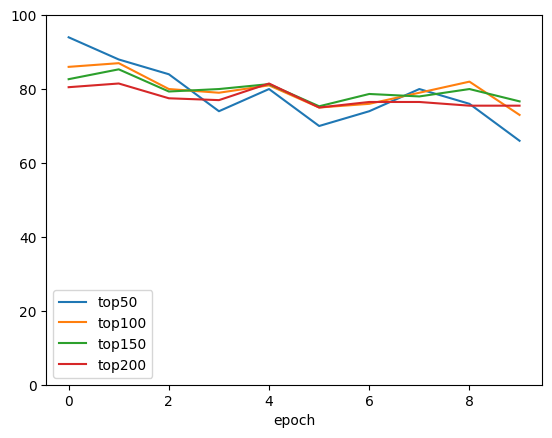

In [85]:
ax = df.plot(x="epoch", y="top50")
ax = df.plot(x="epoch", y="top100", ax=ax)
ax = df.plot(x="epoch", y="top150", ax=ax)
ax = df.plot(x="epoch", y="top200", ax=ax)
ax.set_ylim(0, 100)

In [94]:
df.loc[0].values[0:len(sel_sizes) + 1]

array([ 0.        , 93.99999976, 86.00000143, 82.66666532, 80.50000072,
       80.400002  , 80.66666722, 78.285712  , 76.99999809, 75.33333302,
       73.60000014, 72.36363888, 72.16666937, 70.76923251, 70.28571367,
       69.33333278, 68.87500286, 67.29411483, 65.66666961, 65.15789628,
       63.89999986, 62.95238137, 61.90909147, 60.34782529, 58.83333087,
       57.44000077])

## Comparation

In [73]:
dm.hparams.use_denoised_data = True
dm.hparams.train_batch_size = 256
dm.setup("tracing")
def loss_fn(pred_fn, batch):
        labels = batch["label"]
        preds = pred_fn(batch)
        return F.cross_entropy(preds, labels)

def eval_ckpt(ckpt):
        lit_model.load_state_dict(torch.load(ckpt, map_location=device)["state_dict"])
        grad_extractor = RuntimeGradientExtractor(
                lit_model, 
                split_params=lambda params: (params[:-2], params[-2:]), 
                merge_params=lambda w1, w2: w1 + w2,
                loss_fn=loss_fn,
                input_sample=next(iter(train_loader)))  
        neibor_inds = cal_neibor_matrices(lit_model, ref_loader=dm.test_dataloader(), trace_loader=train_loader, k=199)
        result_df = eval(dm, lit_model, grad_extractor, label_from_batch=lambda b: b["label"], neighbor_matrices=neibor_inds, k_colected=list(range(10, 200, 20)))
        return result_df

In [78]:
imdb_real_train_path = Path("outputs/imdb/flip0_bert/")
for ckpt in imdb_real_train_path.rglob("checkpoints/epoch=*.ckpt"):
    print(ckpt)
    result_df = eval_ckpt(ckpt)
    result_df.to_csv(str(ckpt)+".csv")

outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8616.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.53it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.40s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1427.43it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8531.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.42it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.40s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1393.90it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8799.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.51it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.44s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1534.11it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8812.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.44it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.44s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1360.42it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8716.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.46it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 1it [00:07,  7.58s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f427822b160>
Traceback (most recent call last):
  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f427822b160>
Traceback (most recent call last):
Exception ignored in:   File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__

outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8744.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.34it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 0it [00:00, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f427822b160><function _MultiProcessingDataLoaderIter.__del__ at 0x7f427822b160>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  F

outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8788.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


 14%|█▍        | 3/21 [00:00<00:02,  8.11it/s]Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/

Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.50s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1386.02it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8775.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.30it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1517.59it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8824.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.32it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1326.05it/s]


outputs/imdb/flip0_bert/121_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8831.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1620.53it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8723.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1384.00it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8777.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1399.64it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8753.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.41it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1537.85it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8779.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1526.66it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8836.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.28it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1615.78it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8793.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.34it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.56s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1381.55it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8720.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1351.40it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8796.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.65s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1607.34it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8813.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.66s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1598.18it/s]


outputs/imdb/flip0_bert/122_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8811.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  8.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.56s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1442.28it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=00_val_acc=0.8711.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.56s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1506.03it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=01_val_acc=0.8775.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.31it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1539.59it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=02_val_acc=0.8777.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.31it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1380.13it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=03_val_acc=0.8869.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.31it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.56s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1474.97it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=04_val_acc=0.8829.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.55s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1442.87it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=05_val_acc=0.8776.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.32it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.55s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1419.05it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=06_val_acc=0.8795.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1397.38it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=07_val_acc=0.8728.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1533.18it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=08_val_acc=0.8689.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.55s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1349.73it/s]


outputs/imdb/flip0_bert/123_2023-01-02_12-11-48/checkpoints/epoch=09_val_acc=0.8781.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.34it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1494.79it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=00_val_acc=0.8719.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.33it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1534.87it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.61s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1447.65it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=02_val_acc=0.8765.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.55s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1293.82it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=03_val_acc=0.8801.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.28it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.55s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1490.93it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=04_val_acc=0.8656.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.24it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1323.89it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=05_val_acc=0.8733.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.27it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1417.90it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=06_val_acc=0.8763.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.28it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.51s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1479.11it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=07_val_acc=0.8732.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1462.33it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=08_val_acc=0.8788.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1435.43it/s]


outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=09_val_acc=0.8783.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1356.78it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=00_val_acc=0.8709.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1415.40it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8592.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.32it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1427.35it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=02_val_acc=0.8791.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.58s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1596.91it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=03_val_acc=0.8764.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.28it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.56s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1394.68it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=04_val_acc=0.8707.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  8.63it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.50s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1371.33it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=05_val_acc=0.8769.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.34it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1379.99it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=06_val_acc=0.8796.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.52s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1347.38it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=07_val_acc=0.8708.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.31it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.54s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1351.33it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=08_val_acc=0.8792.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.51s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1414.14it/s]


outputs/imdb/flip0_bert/125_2023-01-02_12-12-57/checkpoints/epoch=09_val_acc=0.8811.ckpt
{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.40it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:15,  7.53s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1444.09it/s]


In [75]:
result_df = eval_ckpt("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt")

{'token_type_ids': torch.Size([64, 128]), 'label': torch.Size([64]), 'input_ids': torch.Size([64, 128]), 'attention_mask': torch.Size([64, 128])}
[torch.Size([64, 128]), torch.Size([64]), torch.Size([64, 128]), torch.Size([64, 128])]


100%|██████████| 21/21 [00:02<00:00,  9.50it/s]


Number of element in each class: [100, 100]


Collect Ref Grads: 2it [00:14,  7.40s/it]
Loop KNN GD: 100%|██████████| 200/200 [00:00<00:00, 1515.37it/s]


In [76]:
result_df

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
0,LossValue,88.000000,86.000001,83.999997,83.999997,79.600000,76.999998,76.285714,75.250000,73.111111,...,65.764707,65.111113,64.736843,63.499999,62.476188,61.272728,59.913045,58.749998,57.359999,55.692309
1,Length_GD,81.999999,85.000002,83.999997,82.499999,80.000001,77.333331,75.714284,75.749999,72.888887,...,65.647060,65.111113,64.631581,63.700002,62.666667,61.181819,59.913045,58.583331,57.359999,55.692309
2,SA_IF_GD,80.000001,73.000002,67.333335,66.000003,66.000003,63.999999,62.000000,60.000002,57.777780,...,47.058824,47.666666,48.421052,49.000001,49.714285,50.545454,51.304346,52.416664,53.680003,55.076921
3,SC_IF_GD,75.999999,77.999997,78.666669,79.000002,79.600000,77.999997,74.571431,74.250001,73.111111,...,65.647060,65.222222,64.315790,63.700002,62.761903,61.090910,59.913045,58.583331,57.359999,55.692309
4,SA_GD,72.000003,74.000001,68.666667,66.500002,66.000003,64.333332,61.714286,60.000002,57.555556,...,47.058824,47.555557,48.526317,48.899999,49.809524,50.636363,51.391304,52.249998,53.680003,55.000001
5,SC_GD,75.999999,77.999997,79.333335,80.000001,78.799999,78.333336,74.571431,74.250001,73.111111,...,65.647060,65.333331,64.315790,63.599998,62.761903,61.090910,59.826088,58.583331,57.359999,55.692309
6,SA_GN,83.999997,87.000000,82.666665,82.499999,79.200000,75.666666,75.428569,75.000000,73.333335,...,55.764705,55.222225,55.368423,54.799998,54.571426,54.727274,54.608697,54.916668,55.199999,55.230767
7,SC_GN,83.999997,87.000000,84.666669,81.999999,79.600000,77.333331,74.571431,75.500000,72.666669,...,65.764707,65.222222,64.631581,63.700002,62.666667,61.181819,59.913045,58.666664,57.359999,55.692309
8,SA_GC,86.000001,83.999997,82.666665,82.499999,78.799999,75.666666,76.285714,74.500000,73.111111,...,65.647060,64.555556,64.210528,63.300002,62.190479,60.818183,59.739131,58.583331,57.040000,55.769229
9,SC_GC,92.000002,83.999997,83.333331,81.000000,78.399998,77.333331,76.571429,74.500000,71.777779,...,65.529412,65.333331,64.105260,63.099998,62.000000,60.909092,59.652174,58.249998,56.800002,55.615383


In [77]:
result_df.sort_values(by="top50", ascending=False)

,method,top50,top100,top150,top200,top250,top300,top350,top400,top450,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
9,SC_GC,92.000002,83.999997,83.333331,81.000000,78.399998,77.333331,76.571429,74.500000,71.777779,...,65.529412,65.333331,64.105260,63.099998,62.000000,60.909092,59.652174,58.249998,56.800002,55.615383
0,LossValue,88.000000,86.000001,83.999997,83.999997,79.600000,76.999998,76.285714,75.250000,73.111111,...,65.764707,65.111113,64.736843,63.499999,62.476188,61.272728,59.913045,58.749998,57.359999,55.692309
8,SA_GC,86.000001,83.999997,82.666665,82.499999,78.799999,75.666666,76.285714,74.500000,73.111111,...,65.647060,64.555556,64.210528,63.300002,62.190479,60.818183,59.739131,58.583331,57.040000,55.769229
6,SA_GN,83.999997,87.000000,82.666665,82.499999,79.200000,75.666666,75.428569,75.000000,73.333335,...,55.764705,55.222225,55.368423,54.799998,54.571426,54.727274,54.608697,54.916668,55.199999,55.230767
7,SC_GN,83.999997,87.000000,84.666669,81.999999,79.600000,77.333331,74.571431,75.500000,72.666669,...,65.764707,65.222222,64.631581,63.700002,62.666667,61.181819,59.913045,58.666664,57.359999,55.692309
1,Length_GD,81.999999,85.000002,83.999997,82.499999,80.000001,77.333331,75.714284,75.749999,72.888887,...,65.647060,65.111113,64.631581,63.700002,62.666667,61.181819,59.913045,58.583331,57.359999,55.692309
2,SA_IF_GD,80.000001,73.000002,67.333335,66.000003,66.000003,63.999999,62.000000,60.000002,57.777780,...,47.058824,47.666666,48.421052,49.000001,49.714285,50.545454,51.304346,52.416664,53.680003,55.076921
39,KNN_GD_150,77.999997,70.999998,69.999999,66.500002,66.000003,63.666666,61.428571,60.250002,57.555556,...,47.058824,47.555557,48.421052,49.000001,49.809524,50.727272,51.391304,52.249998,53.680003,55.076921
36,KNN_GN_130,77.999997,69.999999,69.333333,66.500002,66.000003,64.333332,61.428571,60.250002,57.555556,...,47.058824,47.666666,48.421052,49.000001,49.809524,50.727272,51.304346,52.249998,53.680003,55.000001
35,KNN_GD_130,77.999997,72.000003,69.999999,66.500002,65.600002,64.333332,61.428571,60.250002,57.555556,...,47.058824,47.555557,48.526317,49.000001,49.904761,50.727272,51.478261,52.249998,53.680003,55.000001
